# CIC-IDS2017 EDA - Notebook 4: Correlations & Semantic Analysis

## Phases 6-7: Feature Relationships & Deep-Dive

### Purpose
Identify redundant features and understand special value patterns by attack type.

### Prerequisites
- Run Notebooks 01-03 first

### Structure
**Phase 6: Correlation Analysis**
- 6.1 Feature-Feature Correlations
- 6.2 Highly Correlated Pairs (redundancy)
- 6.3 Multicollinearity Detection (VIF)
- 6.4 Correlation Clusters

**Phase 7: Semantic Deep-Dive**
- 7.1 Init_Win_bytes Sentinel Analysis (the #1 discriminator)
- 7.2 Infinite Values Analysis (Flow Bytes/s, Flow Packets/s)
- 7.3 Attack-Specific Anomalies
- 7.4 Feature Engineering Opportunities

---

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
from scipy import stats
from scipy.cluster import hierarchy
from datetime import datetime
from collections import defaultdict
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

print(f"Phase 6-7 Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Phase 6-7 Analysis started: 2025-12-23 19:20:05


In [2]:
# =============================================================================
# LOAD DATA AND PREVIOUS RESULTS
# =============================================================================

OUTPUT_DIR = "eda_outputs/"

# Load global sample
sample_path = os.path.join(OUTPUT_DIR, 'global_sample.csv')
print(f"Loading: {sample_path}")
df = pd.read_csv(sample_path, low_memory=False)
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Load transform plan from Phase 3
transform_path = os.path.join(OUTPUT_DIR, 'preliminary_transform_plan.json')
with open(transform_path, 'r') as f:
    transform_plan = json.load(f)
print(f"✓ Loaded transform plan")

# Load feature ranking from Phase 5
ranking_path = os.path.join(OUTPUT_DIR, 'feature_ranking.csv')
df_ranking = pd.read_csv(ranking_path, index_col=0)
print(f"✓ Loaded feature ranking ({len(df_ranking)} features)")

# Load target stats
stats_path = os.path.join(OUTPUT_DIR, 'target_analysis_stats.json')
with open(stats_path, 'r') as f:
    target_stats = json.load(f)
print(f"✓ Loaded target stats")

Loading: eda_outputs/global_sample.csv
Dataset shape: 283,138 rows × 87 columns
✓ Loaded transform plan
✓ Loaded feature ranking (65 features)
✓ Loaded target stats


In [3]:
# =============================================================================
# DEFINE FEATURE SETS
# =============================================================================

# Target column
TARGET_COL = 'Label'

# Create Is_Attack if not exists
if 'Is_Attack' not in df.columns:
    df['Is_Attack'] = (df[TARGET_COL] != 'BENIGN').astype(int)

# Get feature sets from transform plan
DROP_FEATURES = set(transform_plan.get('drop', []))
READY_FEATURES = transform_plan.get('ready', [])
SPARSE_FEATURES = transform_plan.get('sparse', [])
PENDING_FEATURES = transform_plan.get('pending_phase7', [])

# Columns to exclude
EXCLUDE_COLS = {'Flow ID', 'Source IP', 'Destination IP', 'Timestamp',
                'Label', 'Is_Attack', 'Attack_Family', 'Source_File',
                'Protocol', 'Destination Port'}

# Get all usable numerical features (not dropped, not excluded)
numerical_features = []
for col in df.columns:
    if col in EXCLUDE_COLS or col in DROP_FEATURES:
        continue
    if df[col].dtype in ['int64', 'int32', 'float64', 'float32']:
        numerical_features.append(col)

numerical_features = sorted(numerical_features)

# Top features from Phase 5
TOP_FEATURES = target_stats.get('top_features', df_ranking.head(20).index.tolist())

print(f"\nFeature sets:")
print(f"  Numerical features for correlation: {len(numerical_features)}")
print(f"  Top discriminating features: {len(TOP_FEATURES)}")
print(f"  Pending Phase 7 analysis: {len(PENDING_FEATURES)}")
print(f"\nPending features: {PENDING_FEATURES}")


Feature sets:
  Numerical features for correlation: 65
  Top discriminating features: 20
  Pending Phase 7 analysis: 4

Pending features: ['Flow Bytes/s', 'Flow Packets/s', 'Init_Win_bytes_backward', 'Init_Win_bytes_forward']


---
# Phase 6: Correlation Analysis

In [4]:
# =============================================================================
# 6.1: FEATURE-FEATURE CORRELATIONS
# =============================================================================

print("=" * 70)
print("6.1: FEATURE-FEATURE CORRELATIONS")
print("=" * 70)

# Prepare data for correlation (handle inf values)
df_corr = df[numerical_features].copy()
df_corr = df_corr.replace([np.inf, -np.inf], np.nan)

# Compute Spearman correlation (robust to outliers and non-linear relationships)
print("\nComputing Spearman correlation matrix...")
corr_matrix = df_corr.corr(method='spearman')

print(f"✓ Correlation matrix: {corr_matrix.shape[0]} × {corr_matrix.shape[1]}")

# Basic stats
# Get upper triangle (excluding diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
all_corrs = upper_tri.stack().values

print(f"\n--- Correlation Distribution ---")
print(f"  Mean |correlation|: {np.abs(all_corrs).mean():.3f}")
print(f"  Median |correlation|: {np.median(np.abs(all_corrs)):.3f}")
print(f"  Max correlation: {all_corrs.max():.3f}")
print(f"  Min correlation: {all_corrs.min():.3f}")

6.1: FEATURE-FEATURE CORRELATIONS

Computing Spearman correlation matrix...
✓ Correlation matrix: 65 × 65

--- Correlation Distribution ---
  Mean |correlation|: 0.430
  Median |correlation|: 0.443
  Max correlation: 1.000
  Min correlation: -0.996


In [5]:
# =============================================================================
# 6.2: HIGHLY CORRELATED PAIRS
# =============================================================================

print("=" * 70)
print("6.2: HIGHLY CORRELATED FEATURE PAIRS")
print("=" * 70)

# Find pairs with |correlation| >= threshold
CORR_THRESHOLD = 0.95

high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) >= CORR_THRESHOLD:
            feat1 = corr_matrix.columns[i]
            feat2 = corr_matrix.columns[j]
            high_corr_pairs.append({
                'feature_1': feat1,
                'feature_2': feat2,
                'correlation': corr,
                'abs_correlation': abs(corr),
            })

df_high_corr = pd.DataFrame(high_corr_pairs).sort_values('abs_correlation', ascending=False)

print(f"\n--- Pairs with |correlation| ≥ {CORR_THRESHOLD} ---\n")
print(f"Found {len(df_high_corr)} highly correlated pairs\n")

if len(df_high_corr) > 0:
    print(f"{'Feature 1':<35} {'Feature 2':<35} {'Correlation':>12}")
    print("-" * 85)
    for _, row in df_high_corr.head(30).iterrows():
        print(f"{row['feature_1']:<35} {row['feature_2']:<35} {row['correlation']:>+12.4f}")
else:
    print("No pairs found above threshold.")

# Count by threshold levels
print(f"\n--- Correlation Thresholds ---")
for thresh in [0.99, 0.95, 0.90, 0.85, 0.80]:
    count = (np.abs(all_corrs) >= thresh).sum()
    print(f"  |r| ≥ {thresh}: {count} pairs")

6.2: HIGHLY CORRELATED FEATURE PAIRS

--- Pairs with |correlation| ≥ 0.95 ---

Found 55 highly correlated pairs

Feature 1                           Feature 2                            Correlation
-------------------------------------------------------------------------------------
Avg Fwd Segment Size                Fwd Packet Length Mean                   +1.0000
Avg Bwd Segment Size                Bwd Packet Length Mean                   +1.0000
Subflow Fwd Bytes                   Total Length of Fwd Packets              +1.0000
Fwd PSH Flags                       SYN Flag Count                           +1.0000
Subflow Bwd Packets                 Total Backward Packets                   +1.0000
Subflow Fwd Packets                 Total Fwd Packets                        +1.0000
Subflow Bwd Bytes                   Total Length of Bwd Packets              +1.0000
Packet Length Std                   Packet Length Variance                   +1.0000
Idle Max                            

In [6]:
# =============================================================================
# IDENTIFY REDUNDANT FEATURES
# =============================================================================

print("\n--- Redundant Feature Groups (r ≥ 0.99) ---\n")

# Find groups of nearly identical features
REDUNDANCY_THRESHOLD = 0.99

# Build adjacency for near-identical features
redundant_pairs = df_high_corr[df_high_corr['abs_correlation'] >= REDUNDANCY_THRESHOLD]

# Group connected features
from collections import defaultdict

def find_groups(pairs_df):
    """Find connected components of redundant features."""
    if len(pairs_df) == 0:
        return []
    
    # Build adjacency
    adj = defaultdict(set)
    all_features = set()
    
    for _, row in pairs_df.iterrows():
        f1, f2 = row['feature_1'], row['feature_2']
        adj[f1].add(f2)
        adj[f2].add(f1)
        all_features.add(f1)
        all_features.add(f2)
    
    # Find connected components
    visited = set()
    groups = []
    
    for feat in all_features:
        if feat in visited:
            continue
        
        # BFS
        group = []
        queue = [feat]
        while queue:
            current = queue.pop(0)
            if current in visited:
                continue
            visited.add(current)
            group.append(current)
            for neighbor in adj[current]:
                if neighbor not in visited:
                    queue.append(neighbor)
        
        if len(group) > 1:
            groups.append(sorted(group))
    
    return groups

redundant_groups = find_groups(redundant_pairs)

print(f"Found {len(redundant_groups)} redundant feature groups:\n")

features_to_drop_redundant = []

for i, group in enumerate(redundant_groups):
    print(f"Group {i+1}: ({len(group)} features)")
    
    # Get ranking for each feature in group
    group_ranks = []
    for feat in group:
        if feat in df_ranking.index:
            rank = df_ranking.loc[feat, 'rank']
            score = df_ranking.loc[feat, 'combined_score']
        else:
            rank = 999
            score = 0
        group_ranks.append((feat, rank, score))
    
    group_ranks.sort(key=lambda x: x[1])  # Sort by rank (lower is better)
    
    # Keep best, mark others for potential drop
    best = group_ranks[0]
    print(f"  KEEP: {best[0]} (rank {int(best[1])}, score {best[2]:.3f})")
    
    for feat, rank, score in group_ranks[1:]:
        print(f"  DROP: {feat} (rank {int(rank)}, score {score:.3f})")
        features_to_drop_redundant.append(feat)
    print()

print(f"\n→ {len(features_to_drop_redundant)} features can be dropped due to redundancy")


--- Redundant Feature Groups (r ≥ 0.99) ---

Found 15 redundant feature groups:

Group 1: (2 features)
  KEEP: Packet Length Mean (rank 43, score 0.274)
  DROP: Average Packet Size (rank 48, score 0.250)

Group 2: (3 features)
  KEEP: Active Max (rank 34, score 0.333)
  DROP: Active Min (rank 35, score 0.326)
  DROP: Active Mean (rank 36, score 0.324)

Group 3: (2 features)
  KEEP: Subflow Fwd Packets (rank 23, score 0.441)
  DROP: Total Fwd Packets (rank 26, score 0.420)

Group 4: (2 features)
  KEEP: Total Length of Fwd Packets (rank 18, score 0.517)
  DROP: Subflow Fwd Bytes (rank 19, score 0.506)

Group 5: (3 features)
  KEEP: Flow Packets/s (rank 25, score 0.422)
  DROP: Fwd Packets/s (rank 28, score 0.411)
  DROP: Flow IAT Mean (rank 30, score 0.398)

Group 6: (3 features)
  KEEP: Idle Max (rank 10, score 0.585)
  DROP: Idle Mean (rank 11, score 0.573)
  DROP: Idle Min (rank 12, score 0.573)

Group 7: (3 features)
  KEEP: Fwd IAT Max (rank 7, score 0.622)
  DROP: Fwd IAT Mean (r

In [7]:
# =============================================================================
# 6.3: MULTICOLLINEARITY DETECTION (VIF)
# =============================================================================

print("=" * 70)
print("6.3: MULTICOLLINEARITY (VIF Analysis)")
print("=" * 70)

# VIF is expensive, so use top features only
# Also need to handle inf/nan



# Use top 25 features for VIF
vif_features = [f for f in TOP_FEATURES[:25] if f in numerical_features]

# Prepare data
df_vif = df[vif_features].copy()
df_vif = df_vif.replace([np.inf, -np.inf], np.nan)
df_vif = df_vif.dropna()

# Standardize to avoid numerical issues
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_vif_scaled = pd.DataFrame(
    scaler.fit_transform(df_vif),
    columns=df_vif.columns
)

print(f"\nComputing VIF for top {len(vif_features)} features...")
print(f"(Using {len(df_vif_scaled):,} complete rows)\n")

# Compute VIF
vif_results = []
for i, col in enumerate(df_vif_scaled.columns):
    try:
        vif = variance_inflation_factor(df_vif_scaled.values, i)
    except:
        vif = np.nan
    vif_results.append({'feature': col, 'VIF': vif})

df_vif_results = pd.DataFrame(vif_results).sort_values('VIF', ascending=False)

print(f"{'Feature':<40} {'VIF':>12} {'Status':>15}")
print("-" * 70)

for _, row in df_vif_results.iterrows():
    vif = row['VIF']
    feat = row['feature']
    
    if pd.isna(vif) or np.isinf(vif):
        status = "SINGULAR"
    elif vif > 10:
        status = "HIGH"
    elif vif > 5:
        status = "MODERATE"
    else:
        status = "OK"
    
    vif_str = f"{vif:.2f}" if pd.notna(vif) and not np.isinf(vif) else "INF"
    print(f"{feat:<40} {vif_str:>12} {status:>15}")

# Summary
high_vif = df_vif_results[df_vif_results['VIF'] > 10]
print(f"\n--- VIF Summary ---")
print(f"  Features with VIF > 10: {len(high_vif)}")
print(f"  Features with VIF > 5: {len(df_vif_results[df_vif_results['VIF'] > 5])}")
print(f"\n  Note: High VIF indicates feature can be predicted from others.")
print(f"  Consider removing or using regularization.")

6.3: MULTICOLLINEARITY (VIF Analysis)

Computing VIF for top 20 features...
(Using 283,138 complete rows)

Feature                                           VIF          Status
----------------------------------------------------------------------
Subflow Fwd Bytes                        33245485013.62            HIGH
Total Length of Fwd Packets              33245485013.62            HIGH
Fwd Packet Length Mean                    24959214.89            HIGH
Avg Fwd Segment Size                      24959214.89            HIGH
Idle Mean                                     4835.63            HIGH
Idle Max                                      1298.78            HIGH
Idle Min                                      1238.61            HIGH
Fwd IAT Max                                     67.27            HIGH
Flow IAT Std                                    25.54            HIGH
Fwd IAT Std                                     15.58            HIGH
Fwd IAT Mean                                    

6.4: CORRELATION VISUALIZATION


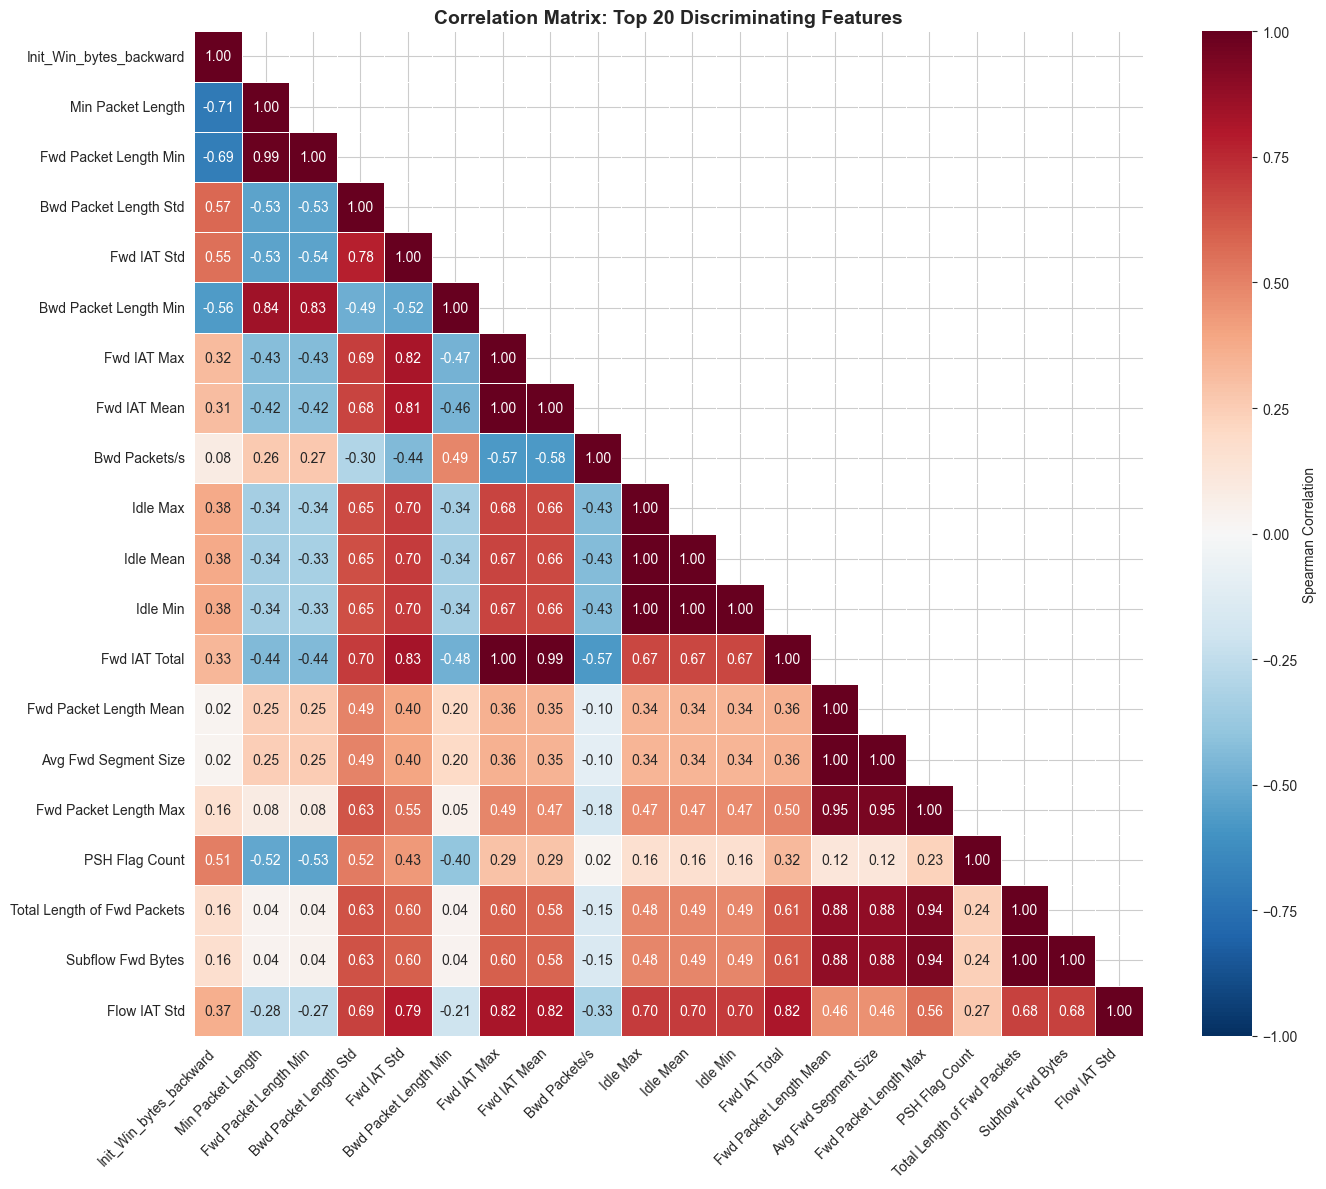

✓ Saved: correlation_heatmap_top20.png


In [8]:
# =============================================================================
# 6.4: CORRELATION HEATMAP (Top Features)
# =============================================================================

print("=" * 70)
print("6.4: CORRELATION VISUALIZATION")
print("=" * 70)

# Heatmap of top features
top_for_heatmap = [f for f in TOP_FEATURES[:20] if f in corr_matrix.columns]
corr_top = corr_matrix.loc[top_for_heatmap, top_for_heatmap]

fig, ax = plt.subplots(figsize=(14, 12))

mask = np.triu(np.ones_like(corr_top, dtype=bool), k=1)

sns.heatmap(
    corr_top,
    mask=mask,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    ax=ax,
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Spearman Correlation'}
)

ax.set_title('Correlation Matrix: Top 20 Discriminating Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'correlation_heatmap_top20.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: correlation_heatmap_top20.png")

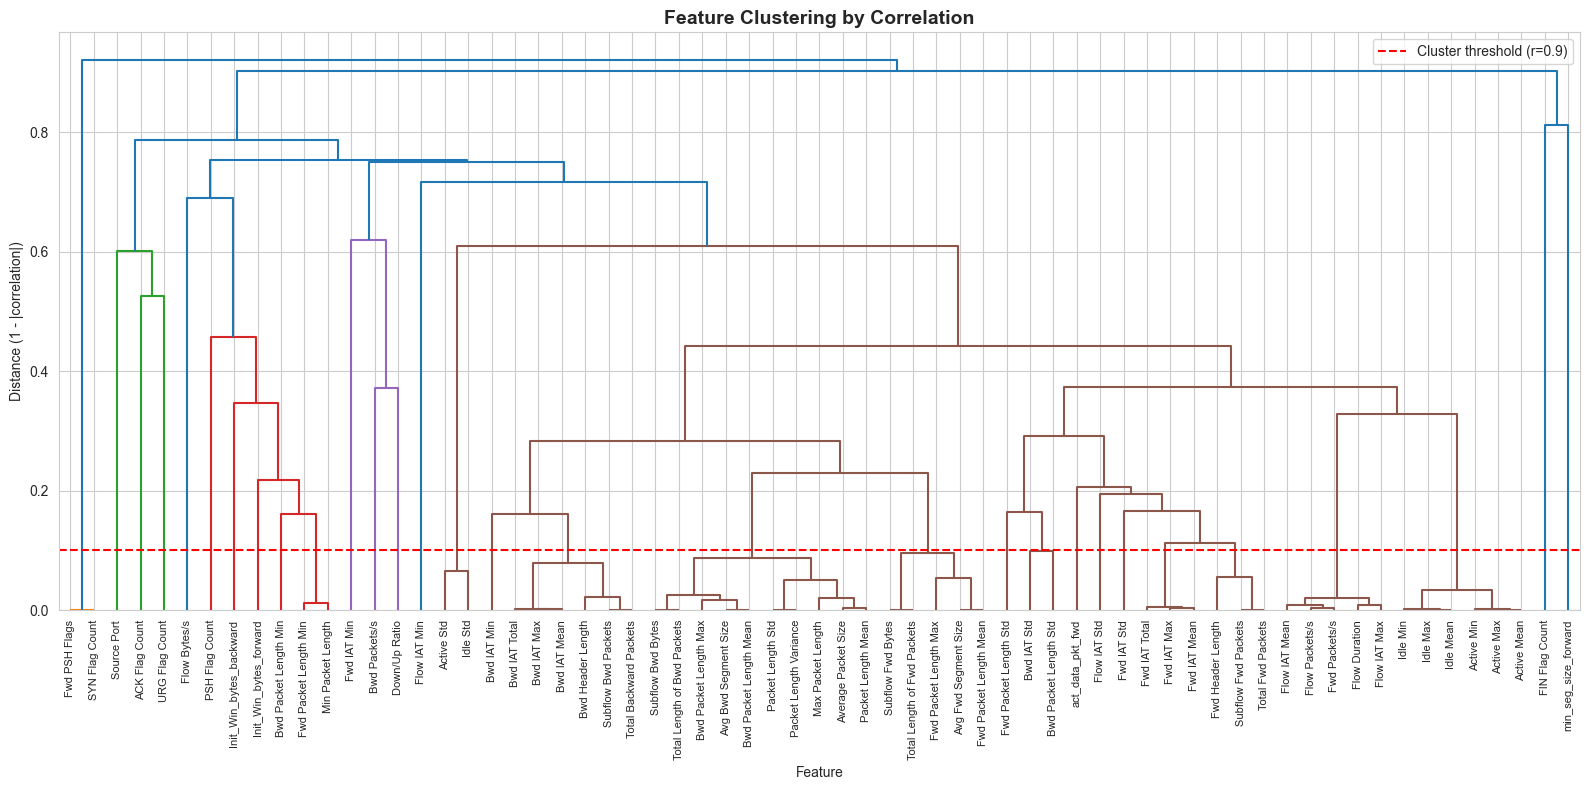

✓ Saved: feature_dendrogram.png

--- Feature Clusters (distance < 0.1, i.e., |r| > 0.9) ---
Number of clusters: 30

Cluster 1 (2 features): SYN Flag Count, Fwd PSH Flags
Cluster 5 (2 features): Min Packet Length, Fwd Packet Length Min
Cluster 14 (2 features): Active Std, Idle Std
Cluster 15 (6 features): Bwd IAT Mean, Bwd IAT Total, Bwd IAT Max, Total Backward Packets, Subflow Bwd Packets...
Cluster 17 (10 features): Subflow Bwd Bytes, Max Packet Length, Packet Length Variance, Packet Length Std, Avg Bwd Segment Size...
Cluster 18 (5 features): Fwd Packet Length Mean, Subflow Fwd Bytes, Total Length of Fwd Packets, Fwd Packet Length Max, Avg Fwd Segment Size
Cluster 19 (2 features): Bwd Packet Length Std, Bwd IAT Std
Cluster 21 (3 features): Fwd IAT Max, Fwd IAT Mean, Fwd IAT Total
Cluster 22 (3 features): Total Fwd Packets, Fwd Header Length, Subflow Fwd Packets
Cluster 26 (5 features): Flow Duration, Fwd Packets/s, Flow IAT Max, Flow IAT Mean, Flow Packets/s
Cluster 27 (6 features): 

In [9]:
# =============================================================================
# HIERARCHICAL CLUSTERING OF FEATURES
# =============================================================================

# Cluster features by correlation
# Use distance = 1 - |correlation|

# Use all numerical features for clustering
corr_for_cluster = corr_matrix.copy()

# Convert to distance matrix
dist_matrix = 1 - np.abs(corr_for_cluster.values)
np.fill_diagonal(dist_matrix, 0)

# Hierarchical clustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Condense distance matrix
dist_condensed = squareform(dist_matrix)

# Linkage
linkage_matrix = linkage(dist_condensed, method='average')

# Plot dendrogram
fig, ax = plt.subplots(figsize=(16, 8))

dendrogram(
    linkage_matrix,
    labels=corr_for_cluster.columns.tolist(),
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax
)

ax.set_title('Feature Clustering by Correlation', fontsize=14, fontweight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Distance (1 - |correlation|)')
ax.axhline(y=0.1, color='r', linestyle='--', label='Cluster threshold (r=0.9)')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_dendrogram.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: feature_dendrogram.png")

# Extract clusters
cluster_labels = fcluster(linkage_matrix, t=0.1, criterion='distance')
feature_clusters = pd.DataFrame({
    'feature': corr_for_cluster.columns,
    'cluster': cluster_labels
}).sort_values('cluster')

print(f"\n--- Feature Clusters (distance < 0.1, i.e., |r| > 0.9) ---")
n_clusters = feature_clusters['cluster'].nunique()
print(f"Number of clusters: {n_clusters}\n")

for cluster_id in sorted(feature_clusters['cluster'].unique()):
    members = feature_clusters[feature_clusters['cluster'] == cluster_id]['feature'].tolist()
    if len(members) > 1:
        print(f"Cluster {cluster_id} ({len(members)} features): {', '.join(members[:5])}{'...' if len(members) > 5 else ''}")

---
# Phase 7: Semantic Deep-Dive

Understanding special values and attack-specific patterns.

In [10]:
# =============================================================================
# 7.1: Init_Win_bytes SENTINEL ANALYSIS
# =============================================================================

print("=" * 70)
print("7.1: Init_Win_bytes SENTINEL ANALYSIS")
print("=" * 70)
print("\nInit_Win_bytes_backward is the #1 discriminating feature.")
print("It has -1 sentinel values (51%) meaning 'no TCP handshake observed'.")
print("\nAnalyzing sentinel patterns by attack type...\n")

# Analyze both Init_Win features
init_win_features = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']

for feat in init_win_features:
    if feat not in df.columns:
        print(f"⚠ {feat} not in dataset")
        continue
    
    print(f"\n--- {feat} ---")
    
    # Overall sentinel rate
    total_sentinel = (df[feat] == -1).sum()
    total_pct = total_sentinel / len(df) * 100
    print(f"Overall sentinel (-1): {total_sentinel:,} ({total_pct:.1f}%)")
    
    # By attack type
    sentinel_by_attack = df.groupby(TARGET_COL).apply(
        lambda x: pd.Series({
            'count': len(x),
            'sentinel_count': (x[feat] == -1).sum(),
            'sentinel_pct': (x[feat] == -1).mean() * 100,
            'zero_count': (x[feat] == 0).sum(),
            'zero_pct': (x[feat] == 0).mean() * 100,
            'median_nonsentinel': x[x[feat] > 0][feat].median() if (x[feat] > 0).any() else np.nan,
        })
    ).sort_values('sentinel_pct', ascending=False)
    
    print(f"\n{'Attack Type':<35} {'Sentinel %':>12} {'Zero %':>10} {'Median (valid)':>15}")
    print("-" * 75)
    
    for attack, row in sentinel_by_attack.iterrows():
        sent_pct = row['sentinel_pct']
        zero_pct = row['zero_pct']
        median = row['median_nonsentinel']
        median_str = f"{median:.0f}" if pd.notna(median) else "N/A"
        print(f"{attack:<35} {sent_pct:>11.1f}% {zero_pct:>9.1f}% {median_str:>15}")

7.1: Init_Win_bytes SENTINEL ANALYSIS

Init_Win_bytes_backward is the #1 discriminating feature.
It has -1 sentinel values (51%) meaning 'no TCP handshake observed'.

Analyzing sentinel patterns by attack type...


--- Init_Win_bytes_backward ---
Overall sentinel (-1): 144,482 (51.0%)

Attack Type                           Sentinel %     Zero %  Median (valid)
---------------------------------------------------------------------------
BENIGN                                     58.1%       4.8%             288
DoS Slowhttptest                           57.3%       4.0%             235
DDoS                                       37.1%       0.0%             229
DoS Slowloris                              29.8%      28.6%             235
DoS Hulk                                   29.2%       0.0%             235
DoS GoldenEye                              24.0%       3.8%             235
FTP-Patator                                18.1%      31.4%             227
Infiltration                 

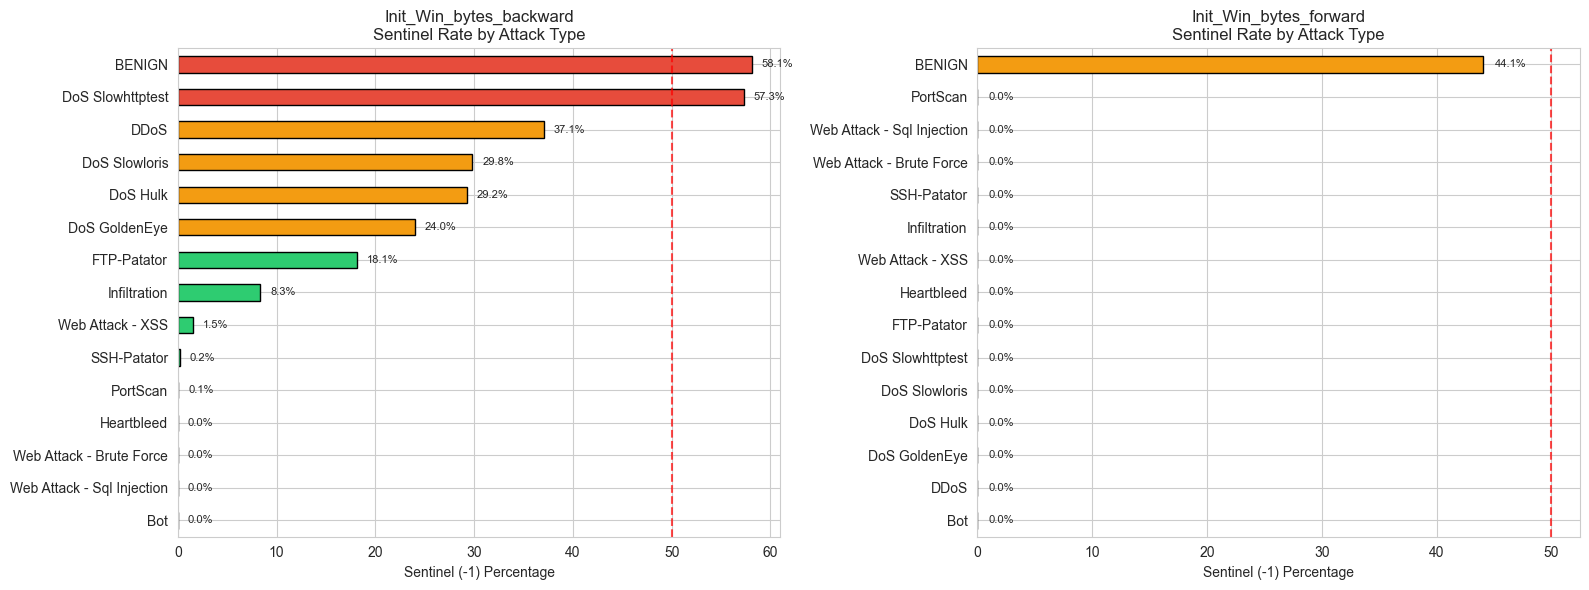

✓ Saved: init_win_sentinel_by_attack.png


In [11]:
# =============================================================================
# INIT_WIN SENTINEL VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, feat in enumerate(init_win_features):
    if feat not in df.columns:
        continue
    
    ax = axes[idx]
    
    # Compute sentinel percentage by attack
    sentinel_pct = df.groupby(TARGET_COL)[feat].apply(lambda x: (x == -1).mean() * 100)
    sentinel_pct = sentinel_pct.sort_values(ascending=True)
    
    # Color by value
    colors = ['#e74c3c' if pct > 50 else '#f39c12' if pct > 20 else '#2ecc71' for pct in sentinel_pct]
    
    sentinel_pct.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
    
    ax.set_xlabel('Sentinel (-1) Percentage')
    ax.set_ylabel('')
    ax.set_title(f'{feat}\nSentinel Rate by Attack Type')
    ax.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
    
    # Add value labels
    for i, (attack, pct) in enumerate(sentinel_pct.items()):
        ax.text(pct + 1, i, f'{pct:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'init_win_sentinel_by_attack.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: init_win_sentinel_by_attack.png")

In [12]:
# =============================================================================
# INIT_WIN INTERPRETATION
# =============================================================================

print("\n--- Init_Win_bytes Interpretation ---\n")

# Key observations
print("KEY FINDINGS:")
print("-" * 50)

# PortScan analysis
portscan_data = df[df[TARGET_COL] == 'PortScan']['Init_Win_bytes_backward']
portscan_sentinel = (portscan_data == -1).mean() * 100
portscan_zero = (portscan_data == 0).mean() * 100

print(f"\n1. PortScan:")
print(f"   - Sentinel (-1): {portscan_sentinel:.1f}%")
print(f"   - Zero: {portscan_zero:.1f}%")
print(f"   → PortScan uses Init_Win=0 (not -1), meaning TCP handshake occurs")
print(f"   → Window size of 0 is distinctive signature of scanning behavior")

# DoS attacks
dos_attacks = ['DoS Hulk', 'DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'DDoS']
print(f"\n2. DoS Attacks:")
for attack in dos_attacks:
    if attack in df[TARGET_COL].values:
        attack_data = df[df[TARGET_COL] == attack]['Init_Win_bytes_backward']
        sentinel = (attack_data == -1).mean() * 100
        median = attack_data[attack_data > 0].median()
        median_str = f"{median:.0f}" if pd.notna(median) else "N/A"
        print(f"   - {attack}: sentinel={sentinel:.1f}%, median={median_str}")

# Web attacks - high Init_Win
web_attacks = df[df[TARGET_COL].str.contains('Web Attack', na=False)]['Init_Win_bytes_backward']
if len(web_attacks) > 0:
    print(f"\n3. Web Attacks:")
    print(f"   - Median: {web_attacks[web_attacks > 0].median():.0f}")
    print(f"   → Anomalously HIGH window size (~28,960)")
    print(f"   → This could be used as a signature for web attack detection")

# BENIGN baseline
benign_data = df[df[TARGET_COL] == 'BENIGN']['Init_Win_bytes_backward']
print(f"\n4. BENIGN (baseline):")
print(f"   - Sentinel (-1): {(benign_data == -1).mean()*100:.1f}%")
print(f"   - Median (valid): {benign_data[benign_data > 0].median():.0f}")

print("\n" + "="*50)
print("RECOMMENDATION:")
print("="*50)
print("""
Create engineered features:
1. has_tcp_handshake: (Init_Win_bytes_backward != -1)
2. is_zero_window: (Init_Win_bytes_backward == 0)
3. is_high_window: (Init_Win_bytes_backward > 10000)
4. init_win_category: categorical (sentinel, zero, normal, high)
""")


--- Init_Win_bytes Interpretation ---

KEY FINDINGS:
--------------------------------------------------

1. PortScan:
   - Sentinel (-1): 0.1%
   - Zero: 99.3%
   → PortScan uses Init_Win=0 (not -1), meaning TCP handshake occurs
   → Window size of 0 is distinctive signature of scanning behavior

2. DoS Attacks:
   - DoS Hulk: sentinel=29.2%, median=235
   - DoS Slowhttptest: sentinel=57.3%, median=235
   - DoS GoldenEye: sentinel=24.0%, median=235
   - DDoS: sentinel=37.1%, median=229

3. Web Attacks:
   - Median: 28960
   → Anomalously HIGH window size (~28,960)
   → This could be used as a signature for web attack detection

4. BENIGN (baseline):
   - Sentinel (-1): 58.1%
   - Median (valid): 288

RECOMMENDATION:

Create engineered features:
1. has_tcp_handshake: (Init_Win_bytes_backward != -1)
2. is_zero_window: (Init_Win_bytes_backward == 0)
3. is_high_window: (Init_Win_bytes_backward > 10000)
4. init_win_category: categorical (sentinel, zero, normal, high)



In [13]:
# =============================================================================
# 7.2: INFINITE VALUES ANALYSIS
# =============================================================================

print("=" * 70)
print("7.2: INFINITE VALUES ANALYSIS")
print("=" * 70)
print("\nFlow Bytes/s and Flow Packets/s have infinite values.")
print("These occur when Flow Duration = 0 (division by zero).\n")

# Analyze infinite values
inf_features = ['Flow Bytes/s', 'Flow Packets/s']

for feat in inf_features:
    if feat not in df.columns:
        print(f"⚠ {feat} not in dataset")
        continue
    
    print(f"\n--- {feat} ---")
    
    # Count infinite values
    inf_mask = np.isinf(df[feat])
    total_inf = inf_mask.sum()
    total_pct = total_inf / len(df) * 100
    print(f"Infinite values: {total_inf:,} ({total_pct:.3f}%)")
    
    # By attack type
    inf_by_attack = df.groupby(TARGET_COL).apply(
        lambda x: pd.Series({
            'count': len(x),
            'inf_count': np.isinf(x[feat]).sum(),
            'inf_pct': np.isinf(x[feat]).mean() * 100,
        })
    ).sort_values('inf_pct', ascending=False)
    
    print(f"\n{'Attack Type':<35} {'Inf Count':>12} {'Inf %':>10}")
    print("-" * 60)
    
    for attack, row in inf_by_attack.iterrows():
        if row['inf_count'] > 0:
            print(f"{attack:<35} {int(row['inf_count']):>12,} {row['inf_pct']:>9.2f}%")

7.2: INFINITE VALUES ANALYSIS

Flow Bytes/s and Flow Packets/s have infinite values.
These occur when Flow Duration = 0 (division by zero).


--- Flow Bytes/s ---
Infinite values: 150 (0.053%)

Attack Type                            Inf Count      Inf %
------------------------------------------------------------
Bot                                            2      1.02%
BENIGN                                       139      0.06%
PortScan                                       8      0.05%
DDoS                                           1      0.01%

--- Flow Packets/s ---
Infinite values: 275 (0.097%)

Attack Type                            Inf Count      Inf %
------------------------------------------------------------
Bot                                            2      1.02%
DoS Hulk                                      96      0.42%
BENIGN                                       168      0.07%
PortScan                                       8      0.05%
DDoS                         

In [14]:
# =============================================================================
# ZERO DURATION FLOWS ANALYSIS
# =============================================================================

print("\n--- Zero Duration Flow Analysis ---\n")

if 'Flow Duration' in df.columns:
    # Zero duration flows
    zero_duration = df['Flow Duration'] == 0
    
    print(f"Total zero-duration flows: {zero_duration.sum():,} ({zero_duration.mean()*100:.2f}%)")
    
    # By attack type
    zero_by_attack = df.groupby(TARGET_COL)['Flow Duration'].apply(
        lambda x: (x == 0).mean() * 100
    ).sort_values(ascending=False)
    
    print(f"\n{'Attack Type':<35} {'Zero Duration %':>15}")
    print("-" * 52)
    
    for attack, pct in zero_by_attack.items():
        if pct > 0.1:
            print(f"{attack:<35} {pct:>14.2f}%")
    
    # What characterizes zero-duration flows?
    print("\n--- Characteristics of Zero-Duration Flows ---")
    zero_flows = df[zero_duration]
    normal_flows = df[~zero_duration]
    
    # Compare key features
    compare_features = ['Total Fwd Packets', 'Total Backward Packets', 
                        'Total Length of Fwd Packets', 'Total Length of Bwd Packets']
    
    print(f"\n{'Feature':<35} {'Zero Duration':>15} {'Normal':>15}")
    print("-" * 65)
    
    for feat in compare_features:
        if feat in df.columns:
            zero_med = zero_flows[feat].median()
            normal_med = normal_flows[feat].median()
            print(f"{feat:<35} {zero_med:>15.1f} {normal_med:>15.1f}")

print("\n" + "="*50)
print("RECOMMENDATION:")
print("="*50)
print("""
For Flow Bytes/s and Flow Packets/s:
1. Create binary feature: is_zero_duration
2. Replace inf with 0 (or very high value) for the rate features
3. Zero-duration flows are mostly PortScan → valuable signal!
""")


--- Zero Duration Flow Analysis ---

Total zero-duration flows: 275 (0.10%)

Attack Type                         Zero Duration %
----------------------------------------------------
Bot                                           1.02%
DoS Hulk                                      0.42%

--- Characteristics of Zero-Duration Flows ---

Feature                               Zero Duration          Normal
-----------------------------------------------------------------
Total Fwd Packets                               2.0             2.0
Total Backward Packets                          0.0             2.0
Total Length of Fwd Packets                     4.0            62.0
Total Length of Bwd Packets                     0.0           122.0

RECOMMENDATION:

For Flow Bytes/s and Flow Packets/s:
1. Create binary feature: is_zero_duration
2. Replace inf with 0 (or very high value) for the rate features
3. Zero-duration flows are mostly PortScan → valuable signal!



In [15]:
# =============================================================================
# 7.3: ATTACK-SPECIFIC ANOMALIES
# =============================================================================

print("=" * 70)
print("7.3: ATTACK-SPECIFIC ANOMALIES")
print("=" * 70)

# Summarize key anomalies discovered
anomalies = {
    'PortScan': {
        'Init_Win_bytes_backward': 'Uses 0 (not -1), indicating TCP handshake with zero window',
        'Bwd Packets/s': 'Extremely high (21,276 vs 25 for BENIGN)',
        'Flow Duration': 'Often 0 (instantaneous)',
    },
    'Web Attack (XSS/Brute Force)': {
        'Init_Win_bytes_backward': 'Anomalously high (~28,960 vs 256 for BENIGN)',
    },
    'DoS Hulk': {
        'Fwd IAT Std': 'Extreme (33M vs ~0 for BENIGN)',
        'Idle Max': 'Extreme (84.6M)',
    },
    'DoS Slowloris': {
        'Fwd IAT Max': 'Extreme (51M) - holds connections open',
    },
    'Infiltration': {
        'Init_Win_bytes_backward': 'High (1,452) - different from other attacks',
        'Packet lengths': 'Similar to BENIGN (stealthy)',
    },
}

print("\n--- Key Anomalies by Attack Type ---\n")

for attack, features in anomalies.items():
    print(f"{attack}:")
    for feat, description in features.items():
        print(f"  • {feat}: {description}")
    print()

7.3: ATTACK-SPECIFIC ANOMALIES

--- Key Anomalies by Attack Type ---

PortScan:
  • Init_Win_bytes_backward: Uses 0 (not -1), indicating TCP handshake with zero window
  • Bwd Packets/s: Extremely high (21,276 vs 25 for BENIGN)
  • Flow Duration: Often 0 (instantaneous)

Web Attack (XSS/Brute Force):
  • Init_Win_bytes_backward: Anomalously high (~28,960 vs 256 for BENIGN)

DoS Hulk:
  • Fwd IAT Std: Extreme (33M vs ~0 for BENIGN)
  • Idle Max: Extreme (84.6M)

DoS Slowloris:
  • Fwd IAT Max: Extreme (51M) - holds connections open

Infiltration:
  • Init_Win_bytes_backward: High (1,452) - different from other attacks
  • Packet lengths: Similar to BENIGN (stealthy)



In [16]:
# =============================================================================
# 7.4: FEATURE ENGINEERING RECOMMENDATIONS
# =============================================================================

print("=" * 70)
print("7.4: FEATURE ENGINEERING RECOMMENDATIONS")
print("=" * 70)

engineering_plan = {
    'From Init_Win_bytes_backward': [
        ('has_tcp_handshake', 'Init_Win_bytes_backward != -1', 'Binary: TCP handshake occurred'),
        ('is_zero_window', 'Init_Win_bytes_backward == 0', 'Binary: PortScan signature'),
        ('is_high_window', 'Init_Win_bytes_backward > 10000', 'Binary: Web Attack signature'),
        ('init_win_valid', 'max(0, Init_Win_bytes_backward)', 'Numeric: sentinel replaced with 0'),
    ],
    'From Flow Duration': [
        ('is_zero_duration', 'Flow Duration == 0', 'Binary: instantaneous flow'),
    ],
    'From Flow Rates': [
        ('flow_bytes_rate_clean', 'replace(inf, 0) in Flow Bytes/s', 'Numeric: cleaned rate'),
        ('flow_packets_rate_clean', 'replace(inf, 0) in Flow Packets/s', 'Numeric: cleaned rate'),
    ],
    'Ratios': [
        ('fwd_bwd_packet_ratio', 'Fwd Packets / (Bwd Packets + 1)', 'Numeric: direction asymmetry'),
        ('fwd_bwd_bytes_ratio', 'Fwd Bytes / (Bwd Bytes + 1)', 'Numeric: size asymmetry'),
    ],
    'Aggregations': [
        ('total_packets', 'Fwd Packets + Bwd Packets', 'Numeric: total volume'),
        ('total_bytes', 'Fwd Bytes + Bwd Bytes', 'Numeric: total size'),
    ],
}

print("\n--- Proposed New Features ---\n")

total_new = 0
for source, features in engineering_plan.items():
    print(f"{source}:")
    for name, formula, description in features:
        print(f"  • {name}: {description}")
        print(f"    Formula: {formula}")
        total_new += 1
    print()

print(f"Total new features proposed: {total_new}")

7.4: FEATURE ENGINEERING RECOMMENDATIONS

--- Proposed New Features ---

From Init_Win_bytes_backward:
  • has_tcp_handshake: Binary: TCP handshake occurred
    Formula: Init_Win_bytes_backward != -1
  • is_zero_window: Binary: PortScan signature
    Formula: Init_Win_bytes_backward == 0
  • is_high_window: Binary: Web Attack signature
    Formula: Init_Win_bytes_backward > 10000
  • init_win_valid: Numeric: sentinel replaced with 0
    Formula: max(0, Init_Win_bytes_backward)

From Flow Duration:
  • is_zero_duration: Binary: instantaneous flow
    Formula: Flow Duration == 0

From Flow Rates:
  • flow_bytes_rate_clean: Numeric: cleaned rate
    Formula: replace(inf, 0) in Flow Bytes/s
  • flow_packets_rate_clean: Numeric: cleaned rate
    Formula: replace(inf, 0) in Flow Packets/s

Ratios:
  • fwd_bwd_packet_ratio: Numeric: direction asymmetry
    Formula: Fwd Packets / (Bwd Packets + 1)
  • fwd_bwd_bytes_ratio: Numeric: size asymmetry
    Formula: Fwd Bytes / (Bwd Bytes + 1)

Aggreg

In [17]:
# =============================================================================
# SAVE RESULTS
# =============================================================================

# Save correlation matrix
corr_path = os.path.join(OUTPUT_DIR, 'correlation_matrix.csv')
corr_matrix.to_csv(corr_path)
print(f"✓ Saved: {corr_path}")

# Save high correlation pairs
high_corr_path = os.path.join(OUTPUT_DIR, 'high_correlation_pairs.csv')
df_high_corr.to_csv(high_corr_path, index=False)
print(f"✓ Saved: {high_corr_path}")

# Save VIF results
vif_path = os.path.join(OUTPUT_DIR, 'vif_results.csv')
df_vif_results.to_csv(vif_path, index=False)
print(f"✓ Saved: {vif_path}")

# Save feature clusters
cluster_path = os.path.join(OUTPUT_DIR, 'feature_clusters.csv')
feature_clusters.to_csv(cluster_path, index=False)
print(f"✓ Saved: {cluster_path}")

# Save Phase 6-7 summary as JSON
phase67_summary = {
    'correlation_analysis': {
        'n_features': len(numerical_features),
        'high_corr_pairs_095': len(df_high_corr),
        'redundant_groups': len(redundant_groups),
        'features_to_drop_redundant': features_to_drop_redundant,
    },
    'vif_analysis': {
        'features_analyzed': len(vif_features),
        'high_vif_count': len(high_vif),
    },
    'semantic_findings': {
        'init_win_sentinel': {
            'description': 'TCP handshake not observed',
            'value': -1,
            'attack_patterns': {
                'PortScan': 'Uses 0 (not -1)',
                'Web_Attack': 'Uses very high values (~28960)',
            }
        },
        'infinite_values': {
            'cause': 'Division by zero (Flow Duration = 0)',
            'mainly_affects': 'PortScan',
        },
    },
    'feature_engineering': engineering_plan,
}

summary_path = os.path.join(OUTPUT_DIR, 'phase67_summary.json')
with open(summary_path, 'w') as f:
    json.dump(phase67_summary, f, indent=2, default=str)
print(f"✓ Saved: {summary_path}")

✓ Saved: eda_outputs/correlation_matrix.csv
✓ Saved: eda_outputs/high_correlation_pairs.csv
✓ Saved: eda_outputs/vif_results.csv
✓ Saved: eda_outputs/feature_clusters.csv
✓ Saved: eda_outputs/phase67_summary.json


In [18]:
# =============================================================================
# PHASE 6-7 COMPLETE: SUMMARY
# =============================================================================

print("=" * 70)
print("PHASE 6-7 COMPLETE: CORRELATION & SEMANTIC ANALYSIS")
print("=" * 70)

print("\n--- Phase 6: Correlation Analysis ---")
print(f"\nFeatures analyzed: {len(numerical_features)}")
print(f"Highly correlated pairs (≥0.95): {len(df_high_corr)}")
print(f"Redundant feature groups (≥0.99): {len(redundant_groups)}")
print(f"Features to drop (redundancy): {len(features_to_drop_redundant)}")

if features_to_drop_redundant:
    print(f"\nRedundant features:")
    for feat in features_to_drop_redundant[:10]:
        print(f"  - {feat}")
    if len(features_to_drop_redundant) > 10:
        print(f"  ... and {len(features_to_drop_redundant) - 10} more")

print("\n--- Phase 7: Semantic Deep-Dive ---")
print("\nInit_Win_bytes_backward (Top Discriminator):")
print("  • Sentinel (-1) = No TCP handshake")
print("  • Zero (0) = PortScan signature")
print("  • High (>10K) = Web Attack signature")

print("\nInfinite Values (Flow Rates):")
print("  • Cause: Flow Duration = 0")
print("  • Mainly affects: PortScan")
print("  • Action: Replace with 0, create is_zero_duration feature")

print("\n--- Feature Engineering Proposed ---")
print(f"  New features: {total_new}")
print("  Key additions:")
print("    • has_tcp_handshake, is_zero_window, is_high_window")
print("    • is_zero_duration")
print("    • Cleaned rate features")
print("    • Fwd/Bwd ratios")

print("\n--- Output Files ---")
output_files = [
    'correlation_matrix.csv',
    'correlation_heatmap_top20.png',
    'feature_dendrogram.png',
    'high_correlation_pairs.csv',
    'vif_results.csv',
    'feature_clusters.csv',
    'init_win_sentinel_by_attack.png',
    'phase67_summary.json',
]

for f in output_files:
    fpath = os.path.join(OUTPUT_DIR, f)
    if os.path.exists(fpath):
        size = os.path.getsize(fpath) / 1024
        print(f"  ✓ {f}: {size:.1f} KB")
    else:
        print(f"  ✗ {f}: not created")

print("\n--- Next Steps ---")
print("  → Notebook 05: Final Preprocessing Plan")
print("  → Consolidate all findings")
print("  → Create preprocessing pipeline")
print("  → Define train/test split strategy")

print("\n" + "=" * 70)
print(f"Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

PHASE 6-7 COMPLETE: CORRELATION & SEMANTIC ANALYSIS

--- Phase 6: Correlation Analysis ---

Features analyzed: 65
Highly correlated pairs (≥0.95): 55
Redundant feature groups (≥0.99): 15
Features to drop (redundancy): 20

Redundant features:
  - Average Packet Size
  - Active Min
  - Active Mean
  - Total Fwd Packets
  - Subflow Fwd Bytes
  - Fwd Packets/s
  - Flow IAT Mean
  - Idle Mean
  - Idle Min
  - Fwd IAT Mean
  ... and 10 more

--- Phase 7: Semantic Deep-Dive ---

Init_Win_bytes_backward (Top Discriminator):
  • Sentinel (-1) = No TCP handshake
  • Zero (0) = PortScan signature
  • High (>10K) = Web Attack signature

Infinite Values (Flow Rates):
  • Cause: Flow Duration = 0
  • Mainly affects: PortScan
  • Action: Replace with 0, create is_zero_duration feature

--- Feature Engineering Proposed ---
  New features: 11
  Key additions:
    • has_tcp_handshake, is_zero_window, is_high_window
    • is_zero_duration
    • Cleaned rate features
    • Fwd/Bwd ratios

--- Output Files